arima is univariate, hence arimax for exogenous variables

In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# %%
df = pd.read_csv("supply_chain_dataset1.csv")
df["Date"] = pd.to_datetime(df["Date"])

sku = df["SKU_ID"].unique()[0]
df = df[df["SKU_ID"] == sku].sort_values("Date")


In [3]:
# %%
def create_features(df):
    df = df.copy()

    df["Month"] = df["Date"].dt.month
    df["DayOfWeek"] = df["Date"].dt.dayofweek

    for lag in [1, 7, 14, 30]:
        df[f"lag_{lag}"] = df["Units_Sold"].shift(lag)

    df["roll_mean_7"] = df["Units_Sold"].rolling(7).mean()
    df["roll_std_7"] = df["Units_Sold"].rolling(7).std()

    return df.dropna()

df_feat = create_features(df)


In [8]:
# %%
y = df_feat["Units_Sold"]

X = df_feat[
    [
        "roll_mean_7",
        "roll_std_7",
        "Month",
        "DayOfWeek",
        "Supplier_Lead_Time_Days",
        "Promotion_Flag",
        "Region"
    ]
]

# One-hot encode Region
X = pd.get_dummies(X, columns=["Region"], drop_first=True)
X = X.astype(float)



In [9]:
# %%
split = len(y) - 60

y_train, y_test = y.iloc[:split], y.iloc[split:]
X_train, X_test = X.iloc[:split], X.iloc[split:]
dates_test = df_feat["Date"].iloc[split:]


In [10]:
# %%
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2,1,2),              # can tune later
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


c:\Users\Guest 1\Desktop\ttl-agentic-ai\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Guest 1\Desktop\ttl-agentic-ai\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Guest 1\Desktop\ttl-agentic-ai\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# %%
pred = results.forecast(
    steps=len(y_test),
    exog=X_test
)



c:\Users\Guest 1\Desktop\ttl-agentic-ai\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [13]:
# %%
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
r2 = r2_score(y_test, pred)

print("ARIMAX Model Performance")
print("-------------------------")
print(f"MAE   : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"R2    : {r2:.3f}")


ARIMAX Model Performance
-------------------------
MAE   : 4.47
RMSE  : 5.42
MAPE  : nan%
R2    : -0.129


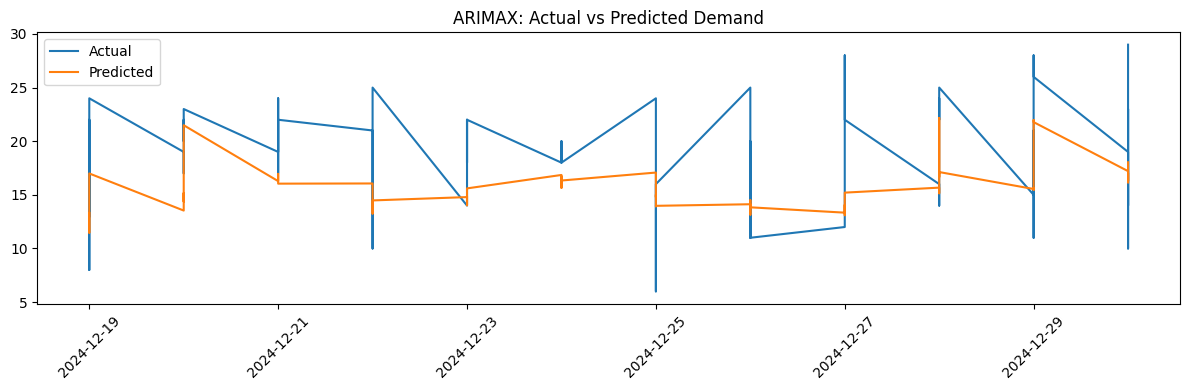

In [14]:
# %%
plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test.values, label="Actual")
plt.plot(dates_test, pred.values, label="Predicted")

plt.legend()
plt.title("ARIMAX: Actual vs Predicted Demand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
